In [3]:
!pip install -q torchmetrics[image]  # for FID (includes torch-fidelity and scipy)
!pip install -q scikit-image        # for PSNR/SSIM if not pre-installed
from torchmetrics.image.fid import FrechetInceptionDistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 127.9/127.9 MB 143.4 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [1]:


# Import libraries
import os
import math
import random
import numpy as np
from PIL import Image
import cv2  # OpenCV for color space conversion
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torchmetrics.image.fid import FrechetInceptionDistance
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


In [ ]:
# Create directories for data if not exist
os.makedirs('/content/drive/MyDrive/div2k', exist_ok=True)
os.makedirs('/content/drive/MyDrive/div2k/DIV2K_train_HR', exist_ok=True)

# Download DIV2K dataset (train HR, train LR X4, val HR, val LR X4)

dataset_urls = {
    "train_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip",
    "train_lr_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip",
    "valid_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "valid_lr_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip"
}
for name, url in dataset_urls.items():
    zip_path = f"{name}.zip"
    if not os.path.exists(zip_path) and not os.path.exists(f"/content/drive/MyDrive/div2k/DIV2K_{name.replace('_', '_').capitalize()}"):
        print(f"Downloading {name}...")
        os.system(f"wget -q -O {zip_path} {url}")
        print(f"Extracting {name}...")
        os.system(f"unzip -q {zip_path} -d div2k")


Extracting train_hr...
Extracting train_lr_x4...
Extracting valid_hr...
Extracting valid_lr_x4...


In [ ]:
# Define a PyTorch Dataset for DIV2K
class Div2KDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, train=True):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.train = train
        # List all image file names in the directory
    
        hr_files = sorted([f for f in os.listdir(hr_dir) if f.endswith('.png') or f.endswith('.jpg')])
        lr_files = sorted([f for f in os.listdir(lr_dir) if f.endswith('.png') or f.endswith('.jpg')])
        # Filter to matching pairs (by prefix)
        # For LR, filenames contain 'x4' suffix before extension
        if self.train:
            # Use all files (should be 800 for training)
            self.hr_files = hr_files
            self.lr_files = lr_files
        else:
            # Use all validation files (100 images)
            self.hr_files = hr_files
            self.lr_files = lr_files
        assert len(self.hr_files) == len(self.lr_files), "HR/LR file count mismatch"
        self.length = len(self.hr_files)
        
        if self.train:
            self.transform = transforms.Compose([
                transforms.ToTensor()  # will convert to [0,1] float and CxHxW
            ])
        else:
            # For validation, just ToTensor (no random augmentation)
            self.transform = transforms.ToTensor()

    def __len__(self):
        # For training, we will sample patches, but we define length as number of images
        return self.length

    def __getitem__(self, idx):
        # Load HR and LR images
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        # Open images
        hr_img = Image.open(hr_path).convert("RGB")
        lr_img = Image.open(lr_path).convert("RGB")
        if self.train:
            # Random crop on the fly to 48x48 LR patch and corresponding 192x192 HR patch
            hr_width, hr_height = hr_img.size  # PIL gives (width, height)
            # Ensure HR size is divisible by 4 (should be in dataset)
            # Compute LR size
            lr_width, lr_height = hr_width // 4, hr_height // 4
            # Random top-left for LR patch
            crop_x = random.randint(0, lr_width - 48)
            crop_y = random.randint(0, lr_height - 48)
            # Compute corresponding HR crop coords
            hr_x = crop_x * 4
            hr_y = crop_y * 4
            # Crop images
            lr_img = lr_img.crop((crop_x, crop_y, crop_x + 48, crop_y + 48))
            hr_img = hr_img.crop((hr_x, hr_y, hr_x + 192, hr_y + 192))
            # Random horizontal flip
            if random.random() < 0.5:
                lr_img = lr_img.transpose(Image.FLIP_LEFT_RIGHT)
                hr_img = hr_img.transpose(Image.FLIP_LEFT_RIGHT)
            # Random vertical flip
            if random.random() < 0.5:
                lr_img = lr_img.transpose(Image.FLIP_TOP_BOTTOM)
                hr_img = hr_img.transpose(Image.FLIP_TOP_BOTTOM)
            # Random 90° rotations
            rot_times = random.randint(0, 3)
            if rot_times:
                lr_img = lr_img.rotate(90 * rot_times, expand=True)
                hr_img = hr_img.rotate(90 * rot_times, expand=True)
        else:
            # No cropping for validation; use full image
            # However, to ensure dimensions are multiples of 4, we can crop off a few pixels if needed
            w, h = lr_img.size
            new_w = w - (w % 1)  # LR width should already be integer (likely no need to crop)
            new_h = h - (h % 1)
            if new_w != w or new_h != h:
                lr_img = lr_img.crop((0, 0, new_w, new_h))
                hr_img = hr_img.crop((0, 0, new_w*4, new_h*4))
        # Transform to tensor [0,1]
        lr_tensor = self.transform(lr_img)
        hr_tensor = self.transform(hr_img)
        return lr_tensor, hr_tensor

# Initialize datasets
train_dataset = Div2KDataset(hr_dir="/content/drive/MyDrive/div2k/DIV2K_train_HR", lr_dir="/content/drive/MyDrive/div2k/DIV2K_train_LR_bicubic/X4", train=True)
val_dataset   = Div2KDataset(hr_dir="/content/drive/MyDrive/div2k/DIV2K_valid_HR",  lr_dir="/content/drive/MyDrive/div2k/DIV2K_valid_LR_bicubic/X4", train=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)  # batch_size=1 for evaluation (one image at a time)
print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")


Loaded 800 training images and 100 validation images.


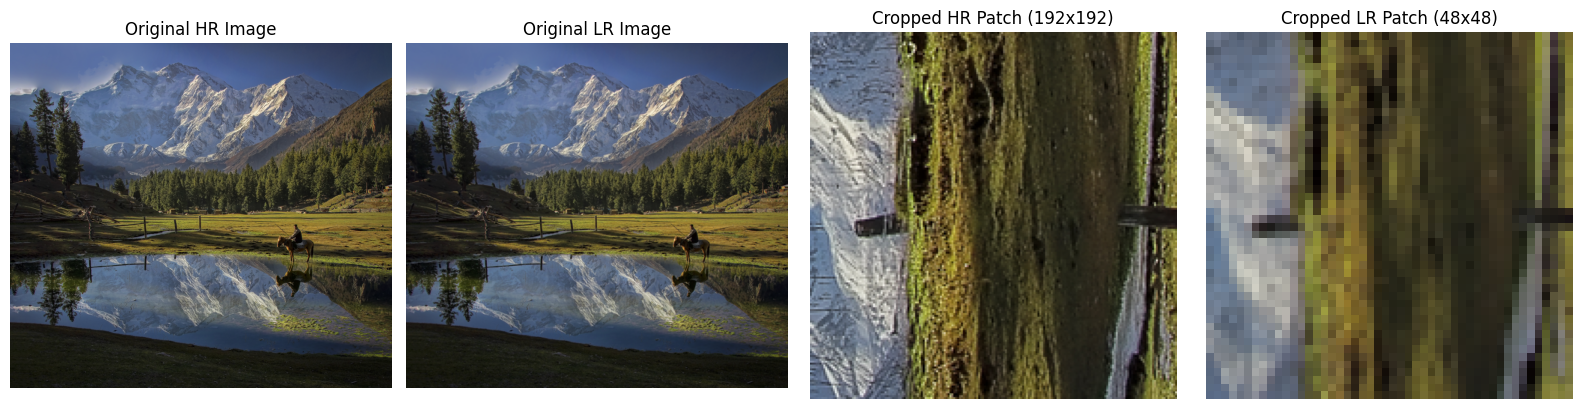

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Load one image pair
idx = 1  # index to visualize
hr_path = os.path.join("/content/drive/MyDrive/div2k/DIV2K_train_HR", sorted(os.listdir("/content/drive/MyDrive/div2k/DIV2K_train_HR"))[idx])
lr_path = os.path.join("/content/drive/MyDrive/div2k/DIV2K_train_LR_bicubic/X4", sorted(os.listdir("/content/drive/MyDrive/div2k/DIV2K_train_LR_bicubic/X4"))[idx])

hr_img = Image.open(hr_path).convert("RGB")
lr_img = Image.open(lr_path).convert("RGB")

# --- Apply same random crop ---
hr_width, hr_height = hr_img.size
lr_width, lr_height = lr_img.size

crop_x = random.randint(0, lr_width - 48)
crop_y = random.randint(0, lr_height - 48)

hr_x = crop_x * 4
hr_y = crop_y * 4

lr_crop = lr_img.crop((crop_x, crop_y, crop_x + 48, crop_y + 48))
hr_crop = hr_img.crop((hr_x, hr_y, hr_x + 192, hr_y + 192))

# Optional: apply augmentation
if random.random() < 0.5:
    lr_crop = lr_crop.transpose(Image.FLIP_LEFT_RIGHT)
    hr_crop = hr_crop.transpose(Image.FLIP_LEFT_RIGHT)
if random.random() < 0.5:
    lr_crop = lr_crop.transpose(Image.FLIP_TOP_BOTTOM)
    hr_crop = hr_crop.transpose(Image.FLIP_TOP_BOTTOM)
rot_times = random.randint(0, 3)
if rot_times:
    lr_crop = lr_crop.rotate(90 * rot_times, expand=True)
    hr_crop = hr_crop.rotate(90 * rot_times, expand=True)

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(hr_img)
axs[0].set_title("Original HR Image")
axs[1].imshow(lr_img)
axs[1].set_title("Original LR Image")
axs[2].imshow(hr_crop)
axs[2].set_title("Cropped HR Patch (192x192)")
axs[3].imshow(lr_crop)
axs[3].set_title("Cropped LR Patch (48x48)")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [3]:
# Define a Residual Dense Block (RDB) with 8 conv layers (dense connections)
class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_channels=64, num_layers=8, residual_beta=0.2):
        """
        in_channels: input (and output) feature channels of the RDB
        growth_channels: number of filters for each internal conv layer
        num_layers: number of dense conv layers inside the block
        residual_beta: residual scaling factor for this block (0.2 in GMFN)
        """
        super(ResidualDenseBlock, self).__init__()
        self.num_layers = num_layers
        self.growth_channels = growth_channels
        self.residual_beta = residual_beta
        # Each dense layer will take all previous outputs as input (dense connectivity)
        # We will create conv layers dynamically in forward using a list to store outputs.
        # However, for simplicity, we'll pre-create ModuleList of convs where each conv
        # has input channels = in_channels + (i * growth_channels).
        modules = []
        for i in range(num_layers):
            in_ch = in_channels + i * growth_channels
            modules.append(nn.Conv2d(in_ch, growth_channels, kernel_size=3, padding=1))
            modules.append(nn.PReLU())  # activation after each conv (except final fusion)
        # Note: PReLU has learnable parameters per channel by default in PyTorch.
        # We'll use one PReLU per conv layer here.
        self.conv_layers = nn.ModuleList(modules)
        # 1x1 convolution for local feature fusion after dense layers
        self.lff_conv = nn.Conv2d(in_channels + num_layers * growth_channels, in_channels, kernel_size=1)
        # No activation after lff_conv (we want to allow negative values for residual)

    def forward(self, x):
        residual = x
        features = x
        # Dense feature propagation
        out_features = [x]  # start with initial input for concatenation
        for i in range(self.num_layers):
            conv = self.conv_layers[2*i]      # i-th conv layer
            act  = self.conv_layers[2*i + 1]  # i-th PReLU
            # Concatenate all previous outputs along channel dim
            concat_feat = torch.cat(out_features, dim=1)
            y = act(conv(concat_feat))
            out_features.append(y)
        # After dense layers, concatenate all outputs (including original x)
        concatenated = torch.cat(out_features, dim=1)
        # Local feature fusion: 1x1 conv to reduce channels back to in_channels
        fused = self.lff_conv(concatenated)
        # Local residual addition with scaling
        return residual + self.residual_beta * fused

# Define Gated Feedback Module (GFM) for one shallow RDB refinement
class GatedFeedbackModule(nn.Module):
    def __init__(self, high_level_channels, low_level_channels):
        """
        high_level_channels: total channels of concatenated high-level features
        low_level_channels: channels of the low-level feature to refine (input to shallow RDB)
        """
        super(GatedFeedbackModule, self).__init__()
        # Gate unit: selects/enhances useful info from high-level features
        # Use 1x1 conv to reduce high-level combined features to same dimension as low-level
        self.gate_conv = nn.Conv2d(high_level_channels, low_level_channels, kernel_size=1)
        self.gate_act = nn.PReLU()
        # Refinement unit: combines low-level and selected high-level info to refine low-level
        self.refine_conv = nn.Conv2d(low_level_channels + low_level_channels, low_level_channels, kernel_size=1)
        self.refine_act = nn.PReLU()

    def forward(self, low_level_feat, high_level_feats):
        """
        low_level_feat: Tensor of shape [B, C_low, H, W] (e.g., input to first RDB of current time step)
        high_level_feats: list of Tensors [B, C_high, H, W], the outputs of selected deep RDBs from previous step.
        """
        # Concatenate multiple high-level features along channel dimension
        if isinstance(high_level_feats, list):
            hl_concat = torch.cat(high_level_feats, dim=1)  # [B, sum(C_high_i), H, W]
        else:
            hl_concat = high_level_feats
        # Gate: select/enhance important high-level info
        hl_enhanced = self.gate_act(self.gate_conv(hl_concat))
        # Refine: fuse low-level with high-level info
        combined = torch.cat([low_level_feat, hl_enhanced], dim=1)  # [B, C_low+C_low, H, W]
        refined_low = self.refine_act(self.refine_conv(combined))
        return refined_low

# Define the full GMFN model
class GMFN(nn.Module):
    def __init__(self, num_iterations=2, num_blocks=7, in_channels=3, out_channels=3,
                 initial_channels=256, growth_channels=64):
        """
        num_iterations: number of feedback iterations (time steps), e.g., 2
        num_blocks: number of RDB blocks per iteration, e.g., 7
        in_channels: input image channels (3 for RGB)
        out_channels: output image channels (3 for RGB)
        initial_channels: number of filters in the first conv layer (C0)
        growth_channels: number of filters (growth) in RDB conv layers (C)
        """
        super(GMFN, self).__init__()
        self.num_iterations = num_iterations
        self.num_blocks = num_blocks
        # Shallow feature extraction
        self.conv_first = nn.Conv2d(in_channels, initial_channels, kernel_size=3, padding=1)
        self.prelu_first = nn.PReLU()
        # Build RDB blocks (shared across iterations, as weights are shared over time)
        self.blocks = nn.ModuleList([ResidualDenseBlock(initial_channels, growth_channels) for _ in range(num_blocks)])
        # Define upsampling (reconstruction) module
        # We'll use two PixelShuffle x2 for 4x scaling
        self.up1 = nn.Sequential(
            nn.Conv2d(initial_channels, initial_channels * 4, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.PixelShuffle(2)  # upscale by 2
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(initial_channels, initial_channels * 4, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.PixelShuffle(2)  # another upscale by 2 (total x4)
        )
        self.conv_final = nn.Conv2d(initial_channels, out_channels, kernel_size=3, padding=1)  # outputs residual image
        # No activation on final conv (residual can be negative/positive)
        # Gated Feedback Module(s)
        # We'll refine the input to the first RDB at time step >1 using multiple deep features from prev step.
        # Select outputs of last 3 RDBs from previous iteration as high-level features.
        high_level_channels = initial_channels * 3  # e.g., 256*3 = 768 if we take 3 block outputs
        self.feedback_gfm = GatedFeedbackModule(high_level_channels=high_level_channels,
                                                low_level_channels=initial_channels)

    def forward(self, lr_input):
        """
        Forward pass for GMFN.
        Returns a tuple (sr_final, sr_outputs_all) where:
         - sr_final is the SR image from the last iteration,
         - sr_outputs_all is a list of SR images from each iteration.
        """
        # Shallow feature
        x = self.prelu_first(self.conv_first(lr_input))  # [B, initial_channels, H, W]
        # Prepare a container to collect SR outputs from each iteration
        sr_outputs = []
        prev_blocks_outputs = None  # will store outputs from previous iteration's blocks
        for t in range(1, self.num_iterations+1):
            # If t > 1, apply feedback: refine shallow features using prev iteration's deep features
            if t > 1 and prev_blocks_outputs is not None:
                # Take multiple high-level features from previous iteration (e.g., last 3 RDB outputs)
                high_level_feats = [prev_blocks_outputs[i] for i in range(self.num_blocks-3, self.num_blocks)]
                # GFM to refine x using those high-level features
                x = self.feedback_gfm(x, high_level_feats)
            # Pass through RDB blocks for this iteration
            current_blocks_outputs = []
            feat = x
            for block in self.blocks:
                feat = block(feat)
                current_blocks_outputs.append(feat)
            # Save outputs for next iteration's feedback
            prev_blocks_outputs = current_blocks_outputs
            # Upsampling reconstruction
            feat_up = self.up1(feat)
            feat_up = self.up2(feat_up)
            residual = self.conv_final(feat_up)
            # Upsample LR for skip connection
            lr_upsampled = torch.nn.functional.interpolate(lr_input, scale_factor=4, mode='bilinear', align_corners=False)
            sr = residual + lr_upsampled  # SR output at this iteration
            sr_outputs.append(sr)
        # Return final SR and list of all SR outputs
        return sr_outputs[-1], sr_outputs

# Instantiate the model
model = GMFN(num_iterations=2, num_blocks=7, initial_channels=256, growth_channels=64).to(device)
print("Model instantiated. Number of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))


Model instantiated. Number of parameters:  21927488


In [ ]:
# Training hyperparameters
num_epochs = 30         # For demonstration; in practice, many more epochs (e.g., 100+ or train until convergence)
learning_rate = 2e-4   # Initial LR as per GMFN pape】
criterion = nn.L1Loss()  # L1 loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Learning rate scheduler: halve LR at epoch 3 (just as an example for demo; adjust as needed)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
train_loss_list = []
val_loss_list = []
# Training loop
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0

    for i, (lr, hr) in enumerate(train_loader, start=1):
        lr = lr.to(device)
        hr = hr.to(device)
        optimizer.zero_grad()
        # Forward pass
        sr_final, sr_all = model(lr)
        # Compute loss: include outputs from all iterations (we have 2 iterations)
        loss = 0.0
        for sr in sr_all:
            loss += criterion(sr, hr)
        loss = loss / len(sr_all)  # average loss from both iterations
        # Backpropagation
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #  print progress for every few batches
        if i % 50 == 0:
            avg_loss = running_loss / 50
            running_loss = 0.0
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}: Avg Loss = {avg_loss:.4f}")
            train_loss_list.append(avg_loss)
    # Step the scheduler
    scheduler.step()
    # Validation PSNR/SSIM after each epoch 
    model.eval()

    with torch.no_grad():
        val_loss_sum = 0.0
        psnr_sum = 0.0
        ssim_sum = 0.0
        for lr, hr in val_loader:
            lr = lr.to(device)
            hr_tensor = hr.to(device)  # עבור חישוב הפסד
            hr_np = hr.numpy()         # עבור PSNR/SSIM

            # Run model
            sr, _ = model(lr)
            sr_clamped = sr.clamp(0.0, 1.0)

            # Loss
            val_loss = criterion(sr_clamped, hr_tensor)
            val_loss_sum += val_loss.item()



            #sr = sr.clamp(0.0, 1.0).detach().cpu().numpy()
            sr_img = (sr_clamped[0].cpu().numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
            hr_img = (hr_np[0].transpose(1, 2, 0) * 255.0).astype(np.uint8)

            # Convert to Y channel
            sr_y = cv2.cvtColor(sr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
            hr_y = cv2.cvtColor(hr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]


            # Compute PSNR and SSIM on Y channel
            psnr_val = peak_signal_noise_ratio(hr_y, sr_y, data_range=255)
            ssim_val = structural_similarity(hr_y, sr_y, data_range=255)
            psnr_sum += psnr_val
            ssim_sum += ssim_val
        avg_psnr = psnr_sum / len(val_dataset)
        avg_ssim = ssim_sum / len(val_dataset)
        avg_val_loss = val_loss_sum / len(val_loader)
        val_loss_list.append(avg_val_loss)
    #print(f"Validation - Epoch {epoch}: PSNR = {avg_psnr:.2f} dB, SSIM = {avg_ssim:.4f}")
    print(f"Validation - Epoch {epoch}: PSNR = {avg_psnr:.2f} dB, SSIM = {avg_ssim:.4f}, Loss = {avg_val_loss:.4f}")
    save_path = f"/content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch{epoch}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

Epoch [1/30] Batch 50: Avg Loss = 0.0313
Validation - Epoch 1: PSNR = 27.40 dB, SSIM = 0.7924, Loss = 0.0279
Model saved to /content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch1.pth
Epoch [2/30] Batch 50: Avg Loss = 0.0285
Validation - Epoch 2: PSNR = 27.61 dB, SSIM = 0.7979, Loss = 0.0273
Model saved to /content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch2.pth
Epoch [3/30] Batch 50: Avg Loss = 0.0289
Validation - Epoch 3: PSNR = 27.76 dB, SSIM = 0.8015, Loss = 0.0268
Model saved to /content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch3.pth
Epoch [4/30] Batch 50: Avg Loss = 0.0280
Validation - Epoch 4: PSNR = 27.83 dB, SSIM = 0.8031, Loss = 0.0266
Model saved to /content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch4.pth
Epoch [5/30] Batch 50: Avg Loss = 0.0277
Validation - Epoch 5: PSNR = 27.86 dB, SSIM = 0.8038, Loss = 0.0264
Model saved to /content/drive/MyDrive/div2k/GMFN_x4_DIV2K_epoch5.pth
Epoch [6/30] Batch 50: Avg Loss = 0.0266
Validation - Epoch 6: PSNR = 27.90 dB, SSIM = 0.8058, Loss = 0.0263
M

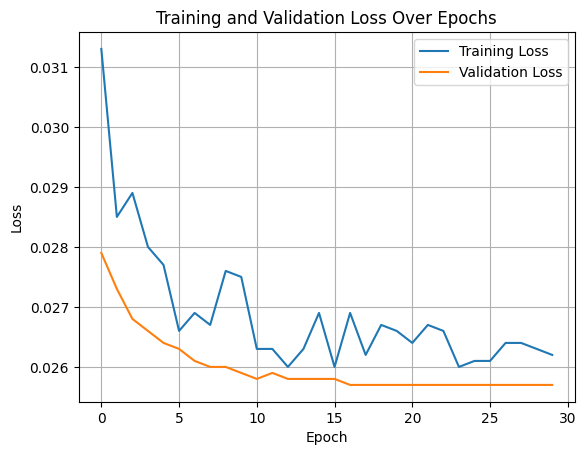

In [ ]:

# Plot training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

model = GMFN(
    num_iterations=2,
    num_blocks=7,
    in_channels=3,
    out_channels=3,
    initial_channels=256,
    growth_channels=64
).to(device)
checkpoint_path = "/content/drive/MyDrive/div2k/GMFN_x4_DIV2K.pth"

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  


GMFN(
  (conv_first): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (prelu_first): PReLU(num_parameters=1)
  (blocks): ModuleList(
    (0-6): 7 x ResidualDenseBlock(
      (conv_layers): ModuleList(
        (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
        (4): Conv2d(384, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): PReLU(num_parameters=1)
        (6): Conv2d(448, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): PReLU(num_parameters=1)
        (8): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): PReLU(num_parameters=1)
        (10): Conv2d(576, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): PReLU(num_parameters=1)
        (12): Conv2d(640, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [17]:
model.eval()

# Initialize metric accumulators
psnr_sum = 0.0
ssim_sum = 0.0
fid_metric = FrechetInceptionDistance(feature=2048).to(device)  # use Inception pool3 features (2048-dim)

with torch.no_grad():
    for lr, hr in val_loader:
        lr = lr.to(device)
        hr = hr.to(device)
        # Get SR output
        sr, _ = model(lr)
        # Clamp and convert to uint8 for metrics
        sr_uint8 = (sr.clamp(0.0, 1.0) * 255).byte()
        hr_uint8 = (hr.clamp(0.0, 1.0) * 255).byte()
        # Calculate PSNR and SSIM on Y channel
        sr_img = sr_uint8[0].permute(1,2,0).cpu().numpy()  # HxWxC
        hr_img = hr_uint8[0].permute(1,2,0).cpu().numpy()
        sr_y = cv2.cvtColor(sr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
        hr_y = cv2.cvtColor(hr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
        psnr_val = peak_signal_noise_ratio(hr_y, sr_y, data_range=255)
        ssim_val = structural_similarity(hr_y, sr_y, data_range=255)
        psnr_sum += psnr_val
        ssim_sum += ssim_val
        # Update FID metrics
        fid_metric.update(hr_uint8, real=True)
        fid_metric.update(sr_uint8, real=False)
        print(f"PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")
# Compute average PSNR, SSIM
avg_psnr = psnr_sum / len(val_dataset)
avg_ssim = ssim_sum / len(val_dataset)
# Compute FID
fid_value = fid_metric.compute().item()

print(f"Validation PSNR (Y-channel): {avg_psnr:.2f} dB")
print(f"Validation SSIM (Y-channel): {avg_ssim:.4f}")
print(f"Validation FID: {fid_value:.2f}")


PSNR: 28.57 dB, SSIM: 0.8442
PSNR: 34.50 dB, SSIM: 0.8990
PSNR: 35.36 dB, SSIM: 0.9540
PSNR: 26.42 dB, SSIM: 0.7711
PSNR: 28.18 dB, SSIM: 0.7816
PSNR: 27.46 dB, SSIM: 0.8444
PSNR: 19.90 dB, SSIM: 0.5016
PSNR: 26.05 dB, SSIM: 0.8024
PSNR: 31.68 dB, SSIM: 0.8628
PSNR: 26.18 dB, SSIM: 0.7886
PSNR: 28.43 dB, SSIM: 0.7887
PSNR: 26.30 dB, SSIM: 0.7793
PSNR: 29.94 dB, SSIM: 0.8666
PSNR: 27.26 dB, SSIM: 0.8857
PSNR: 33.55 dB, SSIM: 0.9199
PSNR: 30.48 dB, SSIM: 0.8297
PSNR: 31.36 dB, SSIM: 0.8797
PSNR: 27.45 dB, SSIM: 0.8833
PSNR: 27.44 dB, SSIM: 0.8152
PSNR: 22.69 dB, SSIM: 0.7376
PSNR: 27.31 dB, SSIM: 0.8606
PSNR: 29.06 dB, SSIM: 0.8481
PSNR: 24.96 dB, SSIM: 0.7895
PSNR: 26.16 dB, SSIM: 0.8563
PSNR: 25.76 dB, SSIM: 0.7865
PSNR: 23.32 dB, SSIM: 0.7288
PSNR: 31.13 dB, SSIM: 0.8607
PSNR: 16.65 dB, SSIM: 0.7155
PSNR: 26.26 dB, SSIM: 0.5301
PSNR: 24.22 dB, SSIM: 0.7242
PSNR: 27.83 dB, SSIM: 0.8296
PSNR: 29.26 dB, SSIM: 0.8607
PSNR: 31.37 dB, SSIM: 0.8867
PSNR: 25.03 dB, SSIM: 0.7730
PSNR: 22.61 dB

In [35]:


def plot_sr_example(lr_tensor, sr_tensor, hr_tensor, idx=None, save_path=None, crop_box=None):
    """
    מצייר את ההשוואה בין LR, SR ו-HR.

    lr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    sr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    hr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    idx: אינדקס להצגה בכותרת (אופציונלי)
    save_path: אם יש נתיב, ישמור לשם את האיור כ־PNG
    crop_box: tuple (left, upper, right, lower) – לחיתוך אזור ספציפי להשוואה
    """
    def tensor_to_np(t):
        if t.dim() == 4:
            t = t[0]
        img = t.cpu().clamp(0, 1).permute(1, 2, 0).numpy()
        return (img * 255).astype(np.uint8)

    lr = tensor_to_np(lr_tensor)
    sr = tensor_to_np(sr_tensor)
    hr = tensor_to_np(hr_tensor)

    if crop_box:
        lr = TF.crop(TF.to_pil_image(torch.tensor(lr).permute(2, 0, 1).float() / 255), *[c//4 for c in crop_box])
        sr = TF.crop(TF.to_pil_image(torch.tensor(sr).permute(2, 0, 1).float() / 255), *crop_box)
        hr = TF.crop(TF.to_pil_image(torch.tensor(hr).permute(2, 0, 1).float() / 255), *crop_box)
        lr = np.array(lr)
        sr = np.array(sr)
        hr = np.array(hr)

    titles = ['Low-Resolution (LR)', 'Super-Resolved (SR)', 'High-Resolution (HR)']
    images = [lr, sr, hr]

    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title, fontsize=14)
        plt.axis('off')
    if idx is not None:
        plt.suptitle(f"Example #{idx}", fontsize=16)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


In [56]:


lr, hr = val_dataset[27]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)


In [57]:
sr_final.shape

torch.Size([1, 3, 1356, 2040])

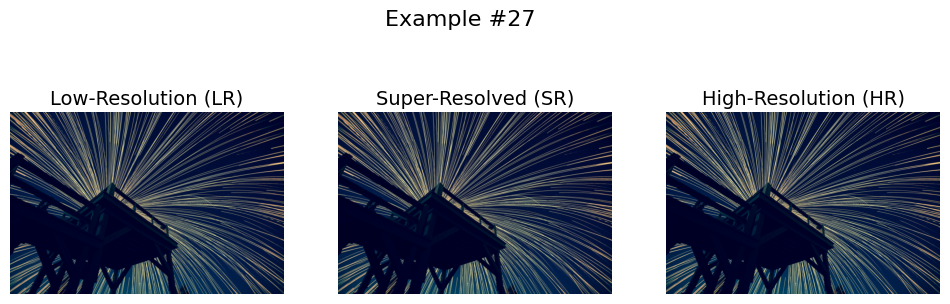

In [45]:
# בהנחה שיש לך שלוש תמונות: lr, sr, hr – טנסורים [1, 3, H, W]
plot_sr_example(lr, sr_final, hr, idx=27)


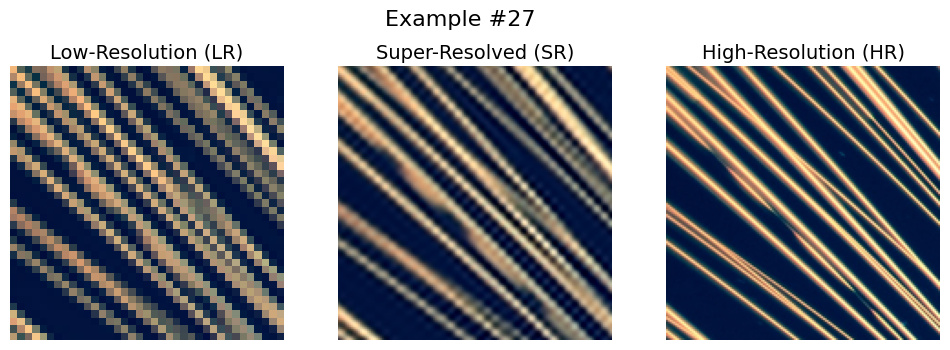

In [59]:
crop_box = (100, 100, 150, 150)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=27, crop_box=crop_box)


In [47]:
lr, hr = val_dataset[43]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

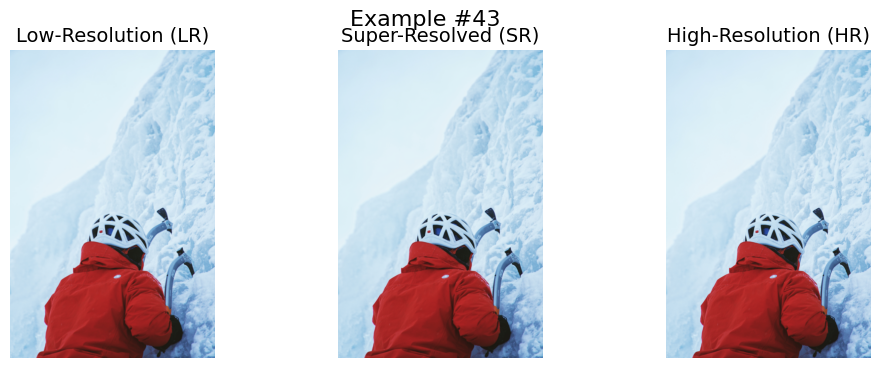

In [48]:
# בהנחה שיש לך שלוש תמונות: lr, sr, hr – טנסורים [1, 3, H, W]
plot_sr_example(lr, sr_final, hr, idx=43)


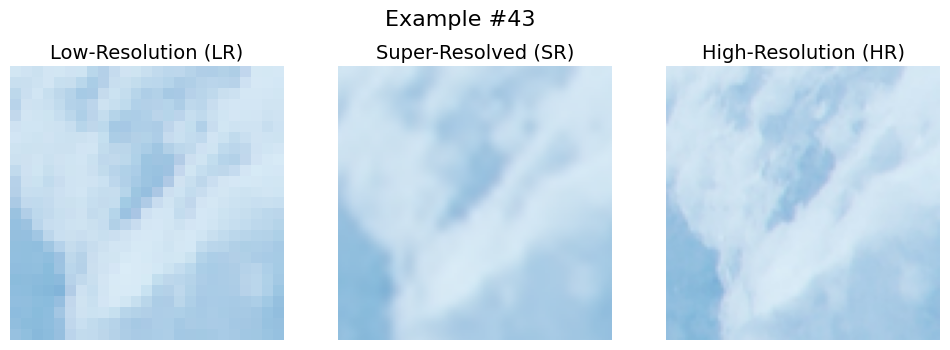

In [55]:
crop_box = (1200, 1200, 100, 100)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=43, crop_box=crop_box)

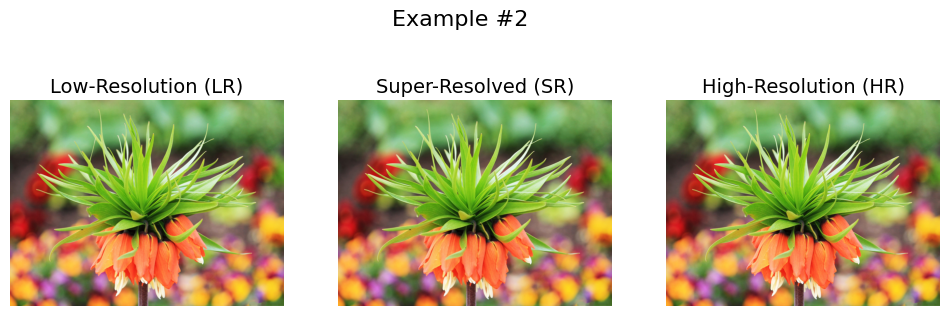

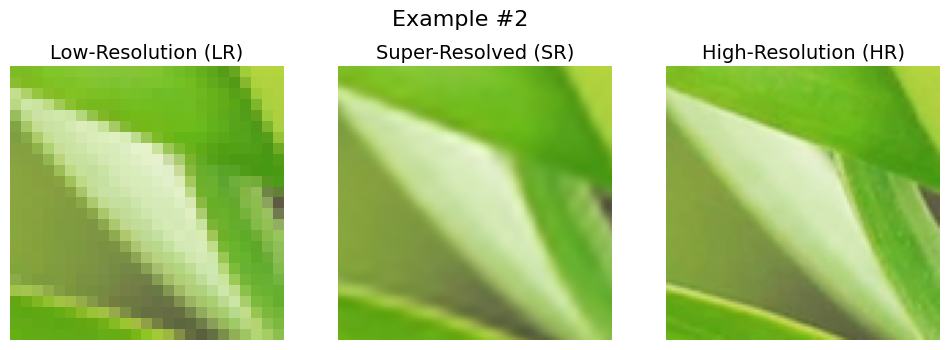

In [39]:
lr, hr = val_dataset[2]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=2)
crop_box = (520, 520, 100, 100)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=2, crop_box=crop_box)

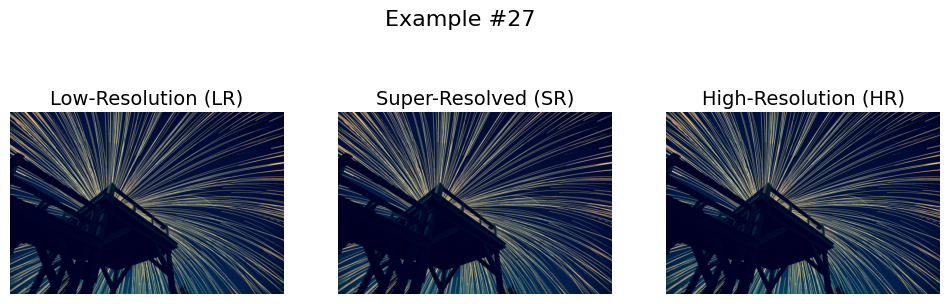

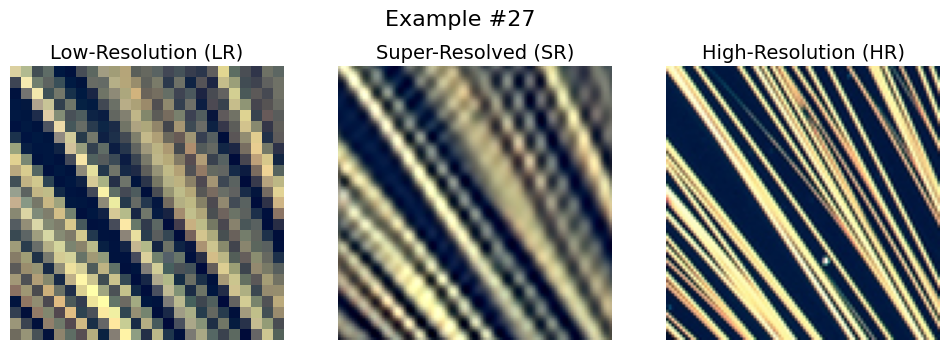

In [40]:
lr, hr = val_dataset[27]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=27)
crop_box = (520, 520, 100, 100)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=27, crop_box=crop_box)

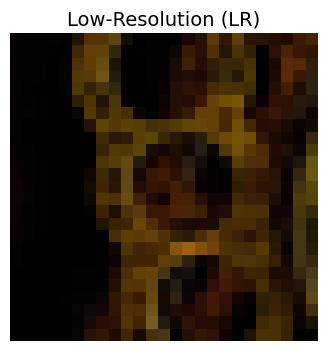

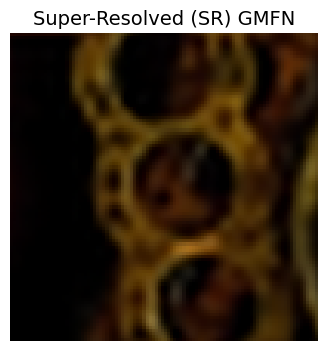

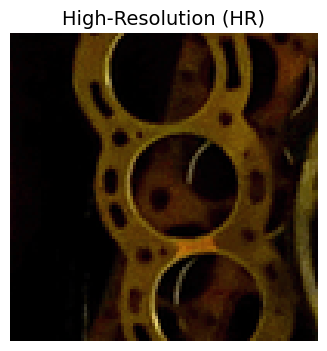

In [6]:
lr, hr = val_dataset[99]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

def tensor_to_np(t):
    if t.dim() == 4:
        t = t[0]
    img = t.cpu().clamp(0, 1).permute(1, 2, 0).numpy()
    return (img * 255).astype(np.uint8)

lr = tensor_to_np(lr)
sr = tensor_to_np(sr_final)
hr = tensor_to_np(hr)
crop_box=(120, 120, 100, 100)
if crop_box:
    lr = TF.crop(TF.to_pil_image(torch.tensor(lr).permute(2, 0, 1).float() / 255), *[c//4 for c in crop_box])
    sr = TF.crop(TF.to_pil_image(torch.tensor(sr).permute(2, 0, 1).float() / 255), *crop_box)
    hr = TF.crop(TF.to_pil_image(torch.tensor(hr).permute(2, 0, 1).float() / 255), *crop_box)
    lr = np.array(lr)
    sr = np.array(sr)
    hr = np.array(hr)

titles = ['Low-Resolution (LR)', 'Super-Resolved (SR) GMFN', 'High-Resolution (HR)']
images = [lr, sr, hr]


for i, (img, title) in enumerate(zip(images, titles)):
    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.title(title, fontsize=14)
    plt.axis('off')

plt.show()